In [1]:
#import relevant libraries

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from math import *
import matplotlib.ticker
import LISA_tools as LISA

## Set physical and LISA constants

In [16]:
""" Cosmological values """
H0      = 69.6      # Hubble parameter today
Omega_m = 0.286     # density parameter of matter

""" LISA arm length """
L = 2.5e9 # meters

""" Transfer Frequency """
f_star = LISA.C/(2.*np.pi*L)

""" Observation Period """
Tobs = 4.*LISA.YEAR

""" Number of Michelson Data Channels """
NC = 2

Gpc = 3.08567758149137e25
G = 6.67430e-11
c = 299792458
Msun = 1.9885e30

constants = np.array([H0, Omega_m, L, f_star, Tobs, NC])

## Import the Noise Curve (corresponding to 4yr LISA lifetime as default)

In [8]:
freq_arr = np.loadtxt('Sn_4yr.dat')[:,0]
Sn_arr = np.loadtxt('Sn_4yr.dat')[:,1]

## Define source parameters

In [87]:
D_l = 1.0*Gpc #distance to source
#masses
m1=1.0e4*Msun 
m2=1.0e4*Msun
m=m1+m2
mu=m1*m2/m
eta=mu/m
Mc=eta**(3./5.)*m

#Overall constant for GW amplitude
A=np.sqrt(5./24.)*(G*Mc/c**3)**(5./6.)/np.pi**(2./3)/(D_l/c)

#initial orbital separation based on delta a/ a_init ~ 10%
a_init=450*G*m/c**2 
f_init=(G*m/a_init**3)**(1./2.)/np.pi

In [116]:
f_init

0.0003384793285342115

## Compute the frequency as a function of time

In [45]:
#Compute the GW frequency as a function of time

def freq(f_init,m,eta,t):
    a_in = ((G*m)/(np.pi*f_init)**2)**(1./3.)
    epsilonrr = (G*m/c**2/a_in)**(5./2)
    a=(a_in**4-256/5*eta*epsilonrr*(G*m)**(1./2)*a_in**(5./2.)*t)**(1./4.)
    return (G*m/a**3)**(1./2.)/np.pi

## Define GW inspiral strain and SNR

In [127]:
def h_insp(f,A):
    #f is array like
    return A*f**(-7./6.)

def S_analytic(f,fstar,L,NC,Tobs):
    Sn = LISA.get_Sn_approx(f,f_star,L,NC)
    Sc = LISA.get_Sc_est(f,Tobs,NC)
    return Sn+Sc

def SNR(f,A,S,delta_f):
    #f,S are array like
    h=h_insp(f,A)
    #Compute SNR using a simple Riemann sum as an approximation to the integral. 
    return (4*np.sum(h**2/S)*delta_f)**(1./2.)

## Determine Frequency Window to study

In [59]:
# Compute the maximum frequency after 4 years
f_max=freq(f_init,m,eta,4*LISA.YEAR)
a_f = ((G*m)/(np.pi*f_max)**2)**(1./3.)

In [123]:
#Define the frequency window to focus on and also define the bin size
delta_f = (f_max-f_init)/100.
freq_window = np.arange(f_init,f_max,delta_f)

In [126]:
f_max

0.00040993829703777767

## Find SNR for the source

In [128]:
# Find the approximate S_n and S_c and add them to get the total noise (this is an excellent approximation for early frequencies)
S_tot_window = S_analytic(freq_window,f_star,L,NC,Tobs)
#Find the resulting SNR 
rho = SNR(freq_window,A,S_tot_window,delta_f)

In [129]:
rho

15.59681892839082

## Plot source strain vs detector noise strain

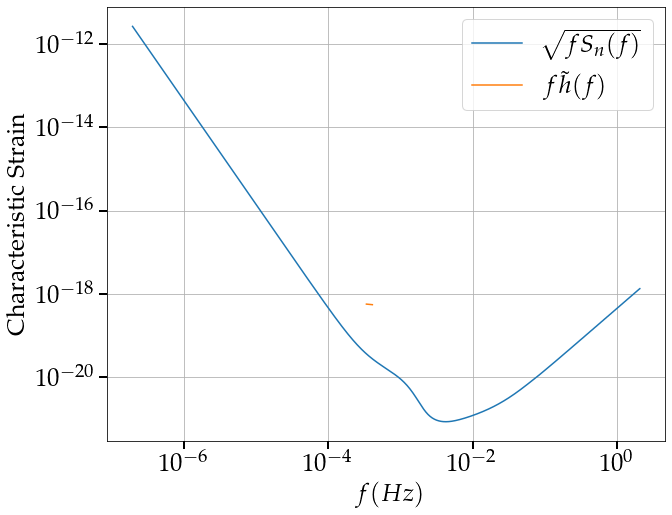

In [138]:
fig,ax=plt.subplots(figsize=(10,8))

""" Set the font and style of plot """
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


ax.set_xlabel(r'$f (Hz) $', fontsize=25)
ax.set_ylabel(r'Characteristic Strain',fontsize=25)

ax.tick_params(which='both', width=2, length=8)

ax.plot(freq_arr,(freq_arr*S_analytic(freq_arr,f_star,L,NC,Tobs))**(1./2),label=r'$\sqrt{f S_n(f)}$')
ax.plot(freq_window,freq_window*h_insp(freq_window,A),label=r'$f \tilde{h} (f)$')
#ax.plot(freq_window,(freq_window*S_tot_window)**(1./2),label=r'$\sqrt{f S_n(f)}$')
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim(1.0e-5, 1.0e0)
#ax.set_ylim(3.0e-22, 1.0e-15)
ax.grid('True')
ax.tick_params(labelsize=25)

ax.legend(fontsize=25)
plt.savefig('sourceVSdetectorStrain_m_2e4_equal_mass_1Gpc_4yr_a_init_450m.pdf',dpi=fig.dpi,bbox_inches='tight')